## 패키지 install

In [1]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 19.4 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 KB 27.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp38-cp38-linux_x86_64.whl size=689004 sha256=196dc46b07628bfd7a26a3f521e1e31bc62c91f6d0fc6540409bf2f814faada6
  Stored in directory: /root/.cache/pip/wheels/b6/93/9d/2237550c409eb3ed725d6302b7897ddd9a037b40cef66dcd9c
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-h6lz8ew8
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-h6lz8ew8
  Resolved https://****@github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 881.9/881.9 MB 139.7 MB/s eta 0:00:01tcmalloc: large alloc 1102397440 bytes == 0x3ab62000 @  0x7fb317bd1680 0x7fb317bf1da2 0x5f714c 0x64d800 0x527022 0x5048

## import package

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [4]:
#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [5]:
#GPU 사용
device = torch.device("cuda:0")
# device = torch.device("cpu")

## Dataset

In [6]:
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [7]:
import pandas as pd

data = pd.read_csv('한국어_단발성_대화_정리3000.csv')

In [8]:
data.loc[(data['Emotion'] == "행복"), 'Emotion'] = 0  #행복 => 0
data.loc[(data['Emotion'] == "중립"), 'Emotion'] = 1  #중립 => 1
data.loc[(data['Emotion'] == "불안"), 'Emotion'] = 2  #불안 => 2
data.loc[(data['Emotion'] == "슬픔"), 'Emotion'] = 3  #슬픔 => 3
data.loc[(data['Emotion'] == "분노"), 'Emotion'] = 4  #분노 => 4

In [9]:
# Setting parameters
max_len = 64
batch_size = 32
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [10]:
data_list = []
for ques, label in zip(data['Sentence'], data['Emotion']):
    data = []   
    data.append(ques)
    data.append(str(label))

    data_list.append(data)

In [11]:
dataset_size = len(data_list)
train_size = int(dataset_size * 0.7)
validation_size = int(dataset_size * 0.15)
test_size = dataset_size - train_size - validation_size

print(dataset_size, train_size, validation_size, test_size)

14438 10106 2165 2167


In [12]:
from torch.utils.data import Dataset, DataLoader, random_split

dataset_train, dataset_validation, dataset_test = random_split(data_list, [train_size, validation_size, test_size])

print(f"Training Data Size : {len(dataset_train)}")
print(f"Validation Data Size : {len(dataset_validation)}")
print(f"Testing Data Size : {len(dataset_test)}")

Training Data Size : 10106
Validation Data Size : 2165
Testing Data Size : 2167


In [13]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [14]:
# 토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

# BERTDataset 클래스 이용, TensorDataset으로 만들어주기
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_validation = BERTDataset(dataset_validation, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [15]:
# 배치 및 데이터로더 설정
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
validation_dataloader = torch.utils.data.DataLoader(data_validation, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=5,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [17]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [18]:
#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [19]:
train_acc_list, train_loss_list = [], []
valid_acc_list, valid_loss_list = [], []

for e in range(num_epochs):
    train_acc = 0.0
    valid_acc = 0.0

    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_acc_list.append(train_acc / (batch_id+1))
    train_loss_list.append(loss)
        
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(validation_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        valid_loss = loss_fn(out,label)
        valid_acc += calc_accuracy(out, label)
    print("epoch {} validation acc {}".format(e+1, valid_acc / (batch_id+1)))

    valid_acc_list.append(valid_acc / (batch_id+1))
    valid_loss_list.append(valid_loss)


<ipython-input-19-21feb2dbdc7d>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.6812348365783691 train acc 0.21875
epoch 1 batch id 201 loss 0.9805668592453003 train acc 0.34530472636815923
epoch 1 train acc 0.4382074610516066


<ipython-input-19-21feb2dbdc7d>:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(validation_dataloader)):


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 1 validation acc 0.6676733193277311


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.1769094467163086 train acc 0.5625
epoch 2 batch id 201 loss 0.8542371988296509 train acc 0.6831467661691543
epoch 2 train acc 0.7082521908471276


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 2 validation acc 0.7145483193277311


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.820332944393158 train acc 0.71875
epoch 3 batch id 201 loss 0.3018558919429779 train acc 0.7919776119402985
epoch 3 train acc 0.8086279819863681


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 3 validation acc 0.7138699229691876


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.5065930485725403 train acc 0.8125
epoch 4 batch id 201 loss 0.2201126515865326 train acc 0.869092039800995
epoch 4 train acc 0.8781189143135345


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 4 validation acc 0.7076768207282913


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.22783800959587097 train acc 0.90625
epoch 5 batch id 201 loss 0.12481281906366348 train acc 0.9225746268656716
epoch 5 train acc 0.9285007911392406


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 5 validation acc 0.7104122899159664


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.09126991033554077 train acc 0.96875
epoch 6 batch id 201 loss 0.041655562818050385 train acc 0.9455845771144279
epoch 6 train acc 0.9508504746835443


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 6 validation acc 0.7210040266106442


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.05424901843070984 train acc 0.96875
epoch 7 batch id 201 loss 0.03433359041810036 train acc 0.976523631840796
epoch 7 train acc 0.9787381329113924


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 7 validation acc 0.7223608193277311


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.009939361363649368 train acc 1.0
epoch 8 batch id 201 loss 0.05867081135511398 train acc 0.9889614427860697
epoch 8 train acc 0.9885284810126582


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 8 validation acc 0.7200849089635855


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.05765623226761818 train acc 0.96875
epoch 9 batch id 201 loss 0.004543790593743324 train acc 0.9948694029850746
epoch 9 train acc 0.9943631329113924


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 9 validation acc 0.7189250700280112


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.003100860631093383 train acc 1.0
epoch 10 batch id 201 loss 0.002167348051443696 train acc 0.9976679104477612
epoch 10 train acc 0.9963409810126582


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 10 validation acc 0.7210040266106442


In [22]:
train_loss_list_, valid_loss_list_ = [], []

for a, b in zip(train_loss_list, valid_loss_list):
  train_loss_list_.append(float(a))
  valid_loss_list_.append(float(b))

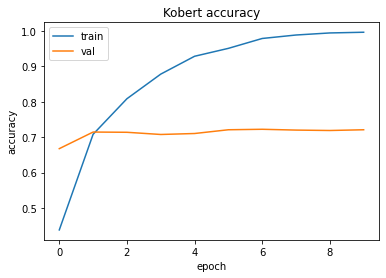

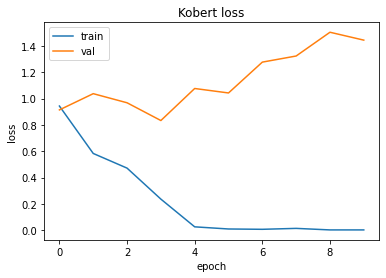

In [24]:
import matplotlib.pyplot as plt
plt.plot(train_acc_list)
plt.plot(valid_acc_list)
plt.title('Kobert accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

plt.plot(train_loss_list_)
plt.plot(valid_loss_list_)
plt.title('Kobert loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()
     

In [25]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(sentence, answer):

    data = [sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits = i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("행복")
            elif np.argmax(logits) == 1:
                test_eval.append("중립")
            elif np.argmax(logits) == 2:
                test_eval.append("불안")
            elif np.argmax(logits) == 3:
                test_eval.append("슬픔")
            elif np.argmax(logits) == 4:
                test_eval.append("분노")
        
        if answer == '0':
            answer = "행복"
        elif answer == '1':
            answer = "중립"
        elif answer == '2':
            answer = "불안"
        elif answer == '3':
            answer = "슬픔"
        elif answer == '4':
            answer = "분노"

        if test_eval[0] != answer:
          print("입력:", sentence, "/ 예측:" , test_eval[0], "/ 실제:", answer)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [26]:
for i in range(test_size):
  model.eval()
  predict(dataset_test[i][0], dataset_test[i][1])

입력:  못난 어른들이 어린이들의 귀와 눈을 더럽히네요. / 예측: 분노 / 실제: 슬픔
입력: 가물치가 미국정착에 성공하셨습니다 / 예측: 중립 / 실제: 행복
입력: 마음 정리를 할 때다 / 예측: 중립 / 실제: 슬픔
입력: 지금 영화보고 나오는 길인데 언니가 더 좋아짐요♡♡ 슬픔&안도ㅜㅜ / 예측: 슬픔 / 실제: 행복
입력:   먼소린지???? / 예측: 불안 / 실제: 중립
입력:  저도 공부에 올인하고싶은데 아버지를 설득하기가 쉽지않을듯합니다. / 예측: 불안 / 실제: 슬픔
입력: 내가너한테 심하게굴어서 벌받나봐.. / 예측: 분노 / 실제: 슬픔
입력: 너무힘들어요 / 예측: 슬픔 / 실제: 불안
입력: 양쪽 정부가 해결 못할 일을 젊은이들이 해 내내요. / 예측: 중립 / 실제: 행복
입력: 이제 병사를 마구 찍어대는 시대가 오겄네요 / 예측: 중립 / 실제: 불안
입력: 나만이해못하는거아니지..? / 예측: 슬픔 / 실제: 불안
입력: 무조건...식단조절 밖에 읍나요? / 예측: 불안 / 실제: 중립
입력: 성대모사도 재밌고 연기도 잘해서 혼술남녀 챙겨보고있어요^^ / 예측: 행복 / 실제: 중립
입력: 누구나 그렇듯이,좋은 대학교에 가기 위해서 였지요. / 예측: 중립 / 실제: 슬픔
입력:  난경북사람인데... / 예측: 슬픔 / 실제: 중립
입력: 웃다 웃다 눈물흘렸네요... / 예측: 슬픔 / 실제: 행복
입력: 어쨌든 못구할것같은데 / 예측: 불안 / 실제: 중립
입력: 삶이 힘드네요어떻게 해쳐나가야 할지 막막합니다!! / 예측: 불안 / 실제: 슬픔
입력:  한국이면 이미 계란날라왔다 / 예측: 중립 / 실제: 분노
입력: 왠지 리콜이 아니라 전면폐기 해야 할것 같다 / 예측: 분노 / 실제: 중립
입력: 난 조인성의 영혼 없는 헛스윙 보면 한숨만 나오던대 ㅋ 언제 은퇴하려나 / 예측: 슬픔 / 실제: 분노
입력: 영장을 왜 기각했는지.참 기막힌다.판사야 / 예측: 분노 / 실제: 중립
입력: 정말 또 챙겨준다면 저만 바보되는거겠

KeyboardInterrupt: ignored